# === SETUP AND IMPORTS ===

In [1]:
# Ensure the latest version of the code is used by re-cloning the repository
!rm -rf Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication
!git clone https://github.com/trongjhuongwr/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication.git
%cd Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication

Cloning into 'Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication'...
remote: Enumerating objects: 3410, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 3410 (delta 51), reused 71 (delta 32), pack-reused 3297 (from 3)
Receiving objects: 100% (3410/3410), 247.81 MiB | 60.29 MiB/s, done.
Resolving deltas: 100% (356/356), done.
/kaggle/working/Deep_Learning-Based_Signature_Forgery_Detection_for_Personal_Identity_Authentication


In [2]:
import pandas as pd
import shutil
import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import transforms
import numpy as np
import os
import sys
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm.notebook import tqdm
import json
import glob
import random

sys.path.append(os.path.abspath(os.getcwd()))

from models.feature_extractor import ResNetFeatureExtractor
from models.meta_learner import MetricGenerator
from dataloader.meta_dataloader import SignatureEpisodeDataset
from utils.model_evaluation import evaluate_and_plot, visualize_hard_examples, compute_metrics, plot_comprehensive_evaluation

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
INPUT_DIM = 512
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 4  # Small batch size for inference stability
NUM_FOLDS = 5

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Random seed set to: {seed}")

SEED = 42
seed_everything(SEED)

print(f"Setup complete. Device: {DEVICE}")

Random seed set to: 42
Setup complete. Device: cuda


# === DATA PREPARATION ===

In [3]:
CEDAR_ROOT_DIR = '/kaggle/input/cedardataset/signatures'
OUTPUT_SPLIT_DIR = '/kaggle/working/splits'
os.makedirs(OUTPUT_SPLIT_DIR, exist_ok=True)
CEDAR_JSON_PATH = os.path.join(OUTPUT_SPLIT_DIR, 'cedar_cross_domain.json')

def generate_cedar_manifest(root_dir, output_path):
    """
    Scans the CEDAR directory structure and generates a standardized JSON manifest.
    CEDAR Naming Convention: 
    - Genuine: 'original_X_Y.png' (User X, Sample Y)
    - Forgery: 'forgeries_X_Y.png' (User X, Sample Y)
    """
    if not os.path.exists(root_dir):
        raise FileNotFoundError(f"CEDAR dataset not found at: {root_dir}")
        
    print(f" > [Data] Scanning CEDAR dataset at: {root_dir}")
    users = {}
    
    # Recursive search for all image files
    files = glob.glob(os.path.join(root_dir, '**', '*.*'), recursive=True)
    valid_exts = ('.png', '.jpg', '.jpeg', '.tif')
    
    for path in files:
        filename = os.path.basename(path).lower()
        if not filename.endswith(valid_exts): continue
        
        # Regex to extract User ID
        # Matches 'original_1_1.png' or 'forgeries_1_1.png'
        match = re.search(r'(original|forgeries)_(\d+)_', filename)
        if match:
            sig_type = match.group(1) # 'original' or 'forgeries'
            uid = match.group(2)      # User ID
            
            if uid not in users: 
                users[uid] = {'genuine': [], 'forged': []}
            
            if sig_type == 'original':
                users[uid]['genuine'].append(path)
            else:
                users[uid]['forged'].append(path)

    # Filter out users with insufficient data
    final_users = {k: v for k, v in users.items() if len(v['genuine']) > 0 and len(v['forged']) > 0}
    
    data = {'cedar_test': final_users}
    
    with open(output_path, 'w') as f:
        json.dump(data, f, indent=4)
        
    print(f" > [Data] Manifest saved to {output_path}")
    print(f" > [Data] Total Users Found: {len(final_users)}")

# Generate the JSON file
generate_cedar_manifest(CEDAR_ROOT_DIR, CEDAR_JSON_PATH)

 > [Data] Scanning CEDAR dataset at: /kaggle/input/cedardataset/signatures
 > [Data] Manifest saved to /kaggle/working/splits/cedar_cross_domain.json
 > [Data] Total Users Found: 55


# === LOADING PRE-TRAINED BHSIG ENSEMBLE MODELS ===

In [4]:
print(f"{'='*20} INITIALIZING ENSEMBLE SYSTEM {'='*20}")

ensemble_models = []
CHECKPOINT_DIR = '/kaggle/input/best-bhsig-model/checkpoints_advanced'

for fold in range(NUM_FOLDS):
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f"bhsig_meta_fold_{fold}_best.pth")
    
    if not os.path.exists(checkpoint_path):
        print(f" [Warning] Checkpoint for Fold {fold+1} not found. Skipping...")
        continue
        
    print(f" > [Model] Loading Fold {fold+1} checkpoint...")
    
    # Initialize Architecture
    feature_extractor = ResNetFeatureExtractor(pretrained=False).to(DEVICE)
    metric_generator = MetricGenerator(embedding_dim=INPUT_DIM).to(DEVICE)
    
    # Load Weights
    checkpoint = torch.load(checkpoint_path, map_location=DEVICE, weights_only=False)
    feature_extractor.load_state_dict(checkpoint['feature_extractor'])
    metric_generator.load_state_dict(checkpoint['metric_generator'])
    
    # Set to Evaluation Mode
    feature_extractor.eval()
    metric_generator.eval()
    
    ensemble_models.append((feature_extractor, metric_generator))

print(f" > [System] Successfully loaded {len(ensemble_models)} models for inference.")
if len(ensemble_models) == 0:
    raise RuntimeError("No models loaded. Please check checkpoint paths.")

==================== INITIALIZING ENSEMBLE SYSTEM ====================
 > [Model] Loading Fold 1 checkpoint...
 > [Model] Loading Fold 2 checkpoint...
 > [Model] Loading Fold 3 checkpoint...
 > [Model] Loading Fold 4 checkpoint...
 > [Model] Loading Fold 5 checkpoint...
 > [System] Successfully loaded 5 models for inference.


# === CROSS-DOMAIN INFERENCE (CEDAR DATASET) ===

In [5]:
# --- 1. PROTOCOL CONFIGURATION ---
K_SHOT = 10
N_QUERY_GENUINE = 14
N_QUERY_FORGERY = 24
INFERENCE_BATCH_SIZE = 4 

print(f"{'='*20} ADVANCED INFERENCE: 5-VIEW MULTI-SCALE TTA {'='*20}")
print(f" > Strategy: 5-Model Ensemble + Rotation & Scaling Augmentation")

# Initialize Dataset
cedar_set = SignatureEpisodeDataset(
    split_file_path=CEDAR_JSON_PATH,
    base_data_dir=None,
    split_name='cedar_test',
    k_shot=K_SHOT,
    n_query_genuine=N_QUERY_GENUINE,
    n_query_forgery=N_QUERY_FORGERY,
    augment=False,
    use_full_path=True
)

cedar_loader = DataLoader(
    cedar_set, 
    batch_size=INFERENCE_BATCH_SIZE, 
    shuffle=False, 
    num_workers=0
)

# --- 2. ADVANCED TTA FUNCTION (ROTATION + SCALING) ---
def extract_robust_features(model, images):
    """
    Generates a consensus feature vector from 5 views:
    1. Original
    2. Rotate -5 deg
    3. Rotate +5 deg
    4. Scale 0.9x (Zoom Out)
    5. Scale 1.1x (Zoom In)
    """
    # 1. Original
    feats = [model(images)]
    
    # 2. Rotations
    feats.append(model(TF.rotate(images, -5)))
    feats.append(model(TF.rotate(images, 5)))
    
    # 3. Scalings (Affine transformation preserves center)
    # Scale 0.9
    feats.append(model(TF.affine(images, angle=0, translate=(0,0), scale=0.9, shear=0)))
    # Scale 1.1
    feats.append(model(TF.affine(images, angle=0, translate=(0,0), scale=1.1, shear=0)))
    
    # Stack and Average Pooling
    # Shape: [5, Batch, Dim] -> Mean -> [Batch, Dim]
    consensus_feat = torch.stack(feats).mean(dim=0)
    
    return consensus_feat

# --- 3. INFERENCE LOOP ---
all_ensemble_scores = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(cedar_loader, desc="Multi-Scale Inference"):
        supports = batch['support_images'].to(DEVICE)
        queries = batch['query_images'].to(DEVICE)
        labels = batch['query_labels'].to(DEVICE)
        
        ensemble_dists = torch.zeros_like(labels, dtype=torch.float)
        
        for fe, mg in ensemble_models:
            bs = supports.size(0)
            for i in range(bs):
                # Apply 5-View TTA to both Support and Query
                # This aligns the feature space regardless of size/orientation
                raw_s = extract_robust_features(fe, supports[i])
                raw_q = extract_robust_features(fe, queries[i])
                
                # Normalize
                s_norm = F.normalize(raw_s, p=2, dim=1)
                q_norm = F.normalize(raw_q, p=2, dim=1)
                
                # Metric Learning Distance
                s_proto = s_norm.mean(dim=0)
                weights = mg(s_proto.unsqueeze(0)).squeeze(0)
                
                dist_sq = (weights * (q_norm - s_proto).pow(2)).sum(dim=1)
                dist = torch.sqrt(torch.clamp(dist_sq, min=1e-8))
                
                ensemble_dists[i] += dist
        
        ensemble_dists /= len(ensemble_models)
        
        for i in range(supports.size(0)):
            all_ensemble_scores.extend(ensemble_dists[i].cpu().numpy())
            all_labels.extend(labels[i].cpu().numpy())

print(" > [System] Inference completed. Ready for evaluation.")

==================== ADVANCED INFERENCE: 5-VIEW MULTI-SCALE TTA ====================
 > Strategy: 5-Model Ensemble + Rotation & Scaling Augmentation


Multi-Scale Inference:   0%|          | 0/14 [00:00<?, ?it/s]

 > [System] Inference completed. Ready for evaluation.


# === QUANTITATIVE EVALUATION & REPORT ===


========== CROSS-DOMAIN EVALUATION REPORT (CEDAR) ==========
Dataset    : CEDAR Signature Dataset (English)
Method     : Ensemble of 5 Models (Trained on BHSig260)
---------------------------------------------
EER        : 32.27%
AUC        : 0.7359
Accuracy   : 67.80%
Threshold  : 0.2634
 > [Visual] Generating evaluation plots to: /kaggle/working/cedar_evaluation_plots.png


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

 > [Saved] Figure saved to: /kaggle/working/cedar_evaluation_plots.png


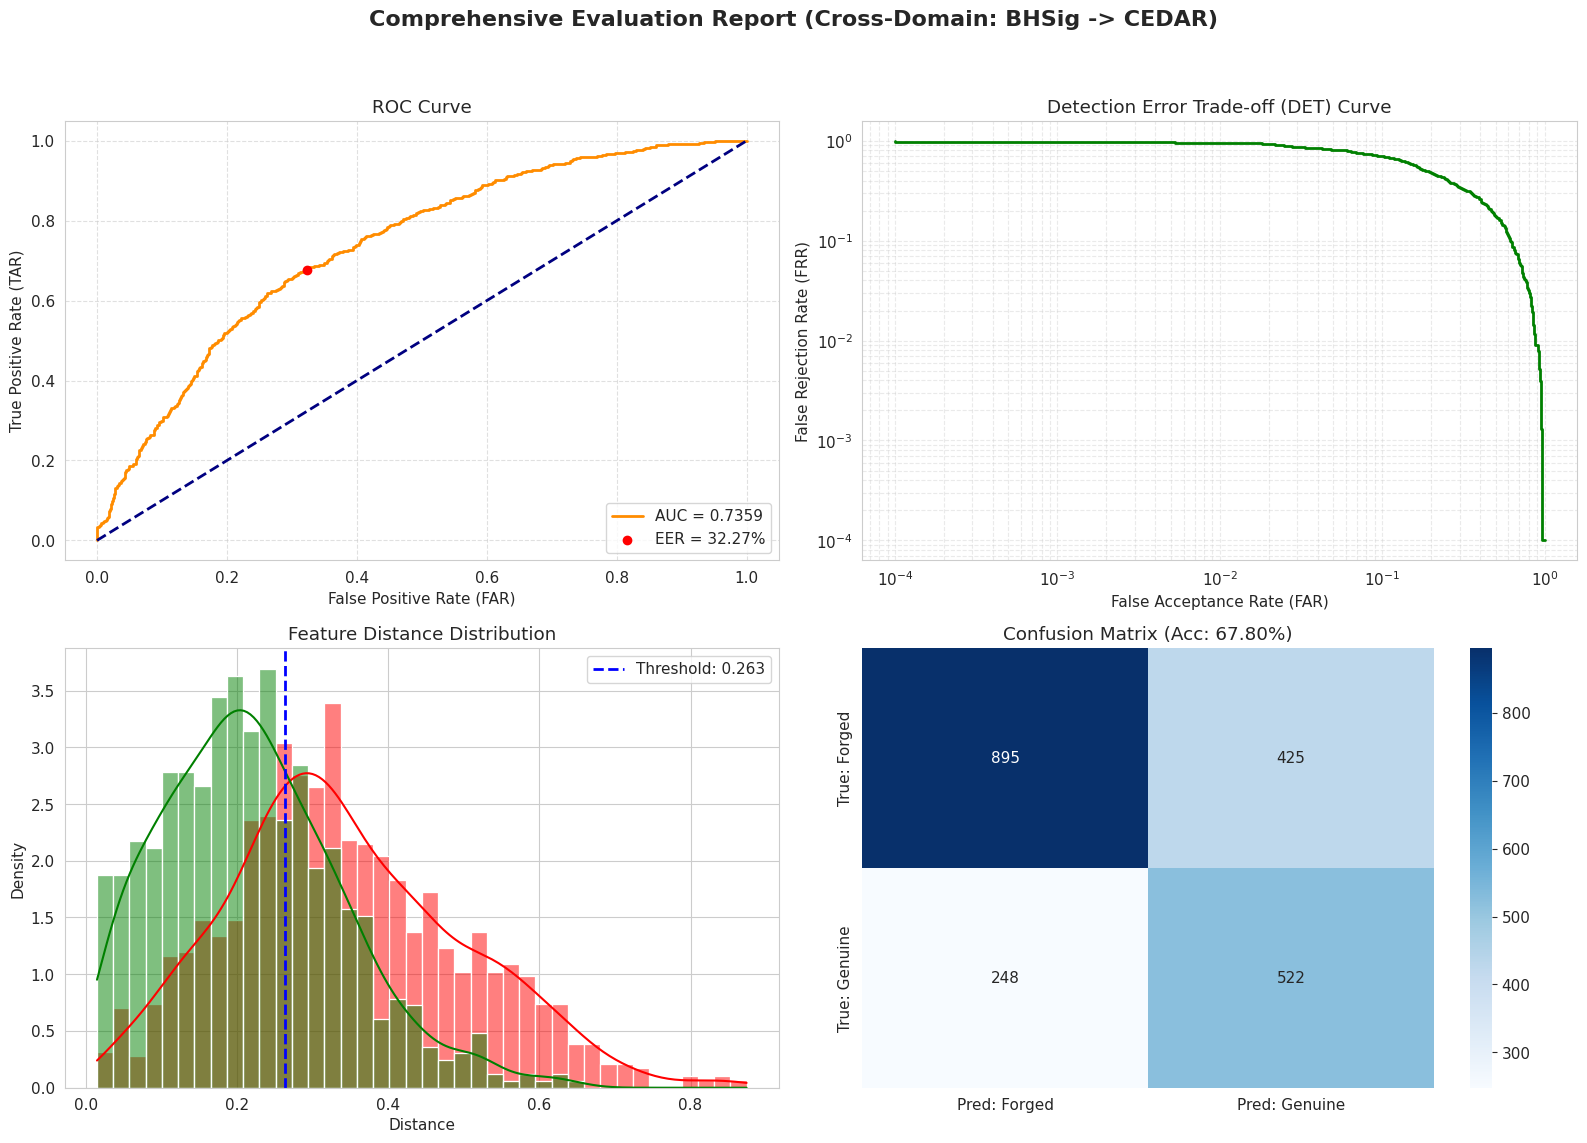

In [6]:
# Calculate Metrics
metrics = compute_metrics(all_labels, all_ensemble_scores)

print(f"\n{'='*10} CROSS-DOMAIN EVALUATION REPORT (CEDAR) {'='*10}")
print(f"Dataset    : CEDAR Signature Dataset (English)")
print(f"Method     : Ensemble of 5 Models (Trained on BHSig260)")
print(f"{'-'*45}")
print(f"EER        : {metrics['eer']:.2%}")
print(f"AUC        : {metrics['auc']:.4f}")
print(f"Accuracy   : {metrics['accuracy']:.2%}")
print(f"Threshold  : {metrics['threshold']:.4f}")
print(f"{'='*45}")

# Save Results to File for Reporting
results_path = '/kaggle/working/cross_domain_cedar_results.txt'
with open(results_path, 'w') as f:
    f.write(f"EER: {metrics['eer']:.4f}\n")
    f.write(f"AUC: {metrics['auc']:.4f}\n")
    f.write(f"ACC: {metrics['accuracy']:.4f}\n")

# Visualization
save_plot_path = '/kaggle/working/cedar_evaluation_plots.png'
print(f" > [Visual] Generating evaluation plots to: {save_plot_path}")
plot_comprehensive_evaluation(metrics, title_suffix="(Cross-Domain: BHSig -> CEDAR)", save_path=save_plot_path)